In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.stats as stats
import numpy.random  as rng

In [38]:
(84.40-83.80) * 100/ 84.40

0.7109004739336593

In [2]:
df = pd.read_csv('iso.csv')

# R1 Temperature Analysis

(0.0, 1.0, 0.0, 1.0)

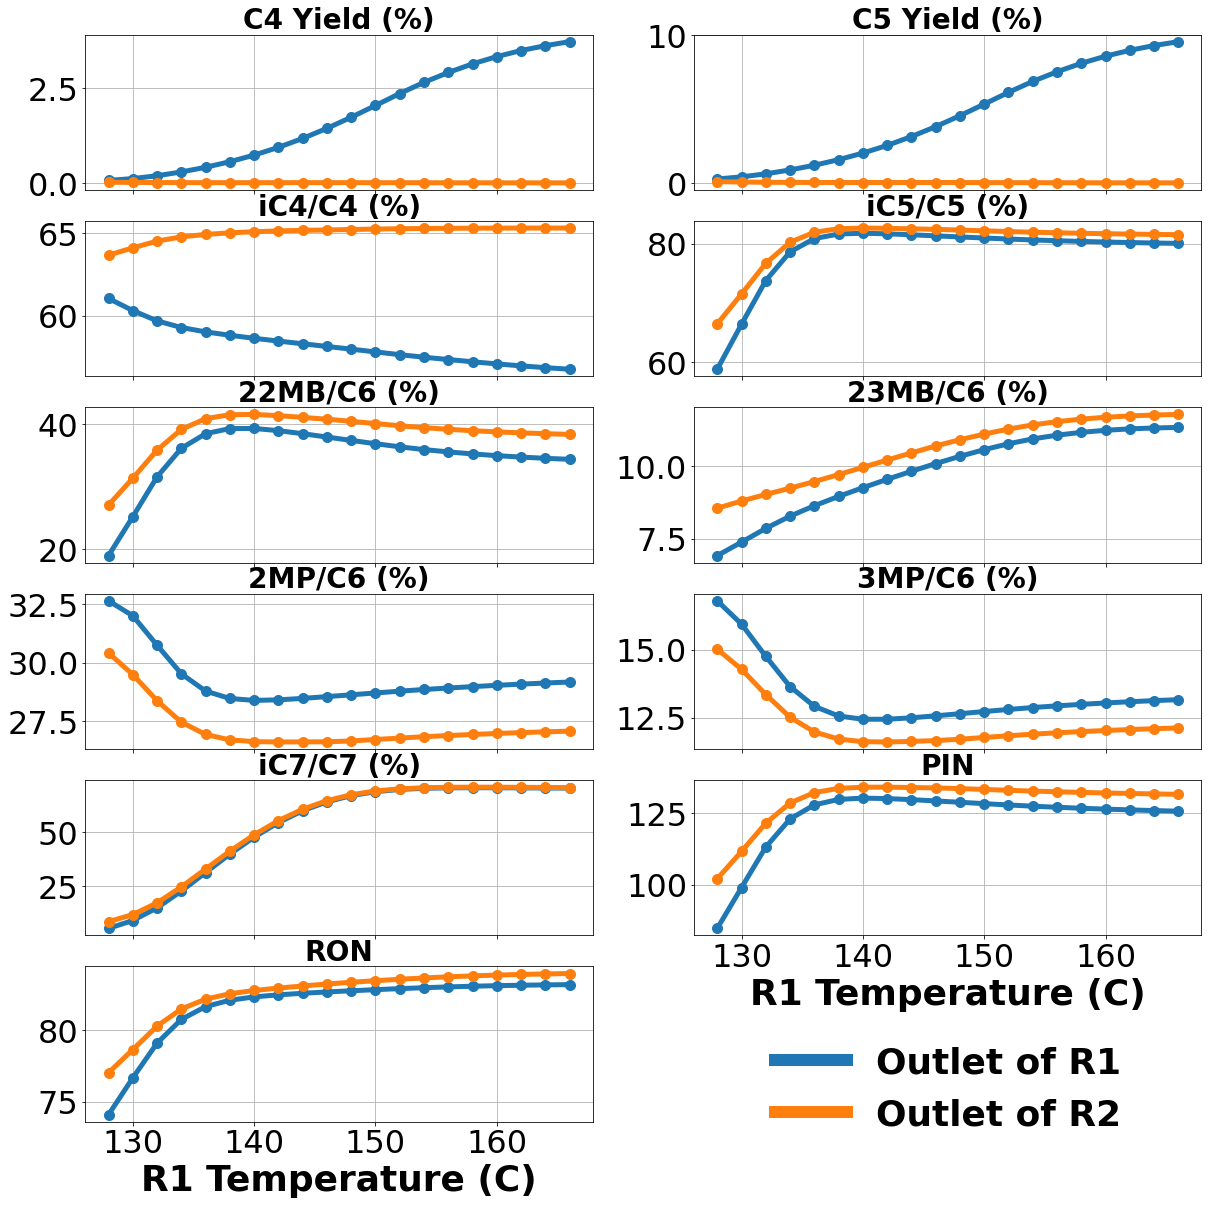

In [3]:
dfe = pd.read_csv('iso2.csv')

sweep_col = 'r1_temp'
sweep_col_title = 'R1 Temperature (C)'
ix = (dfe['r2_temp'] == 128) & (dfe['r1_pressure'] == 50) & (dfe['r2_pressure'] == 50)
sdf = dfe[ix].copy()
sdf.sort_values([sweep_col], inplace=True)

cols_to_plot = [
    ("c4yield", "C4 Yield (%)"),
    ("c5yield", "C5 Yield (%)"),
    ("iso_ratio_c4", "iC4/C4 (%)"),
    ("iso_ratio_c5", "iC5/C5 (%)"),
    ("iso_ratio_c6_22mb", "22MB/C6 (%)"),
    ("iso_ratio_c6_23mb", "23MB/C6 (%)"),
    ("iso_ratio_c6_2mp", "2MP/C6 (%)"),
    ("iso_ratio_c6_3mp", "3MP/C6 (%)"),
    ("iso_ratio_c7", "iC7/C7 (%)"),
    ("pin", "PIN"),
    ("ron", "RON")
]
n = len(cols_to_plot)

f, axes = plt.subplots(int(np.ceil(n / 2)), 2, figsize=(20, 20))
axes = axes.flatten()
for i, r in enumerate(zip(cols_to_plot, axes)):
    col_to_plot, ax = r
    col, title = col_to_plot
    ax.plot(sdf[sweep_col], sdf['r1_%s' % col], linewidth=5, marker='o', markersize=10, label='Outlet of R1')
    ax.plot(sdf[sweep_col], sdf['r2_%s' % col], linewidth=5, marker='o', markersize=10, label='Outlet of R2')
    ax.tick_params(axis='x', labelsize=32)
    ax.tick_params(axis='y', labelsize=32)
    
    if i >= 9:
        ax.set_xlabel(sweep_col_title, fontsize=36, fontweight='bold')
    else:
        ax.set_xticklabels([])
    
    if i == 9:
        # Put a legend below current axis
        legend = ax.legend(loc='upper center', 
                  frameon=False,
                  bbox_to_anchor=(0.5, -.5),
                  fancybox=False, 
                  shadow=False,
                  ncol=1,
                  prop={'weight':'bold', 'size':36})
        for line in legend.get_lines():
            line.set_linewidth(12.0)
    ax.set_title(title, fontsize=28, fontweight='bold')
    ax.grid(True)
axes[-1].axis('off')


# Production Proportions as Function of R1 Temperature

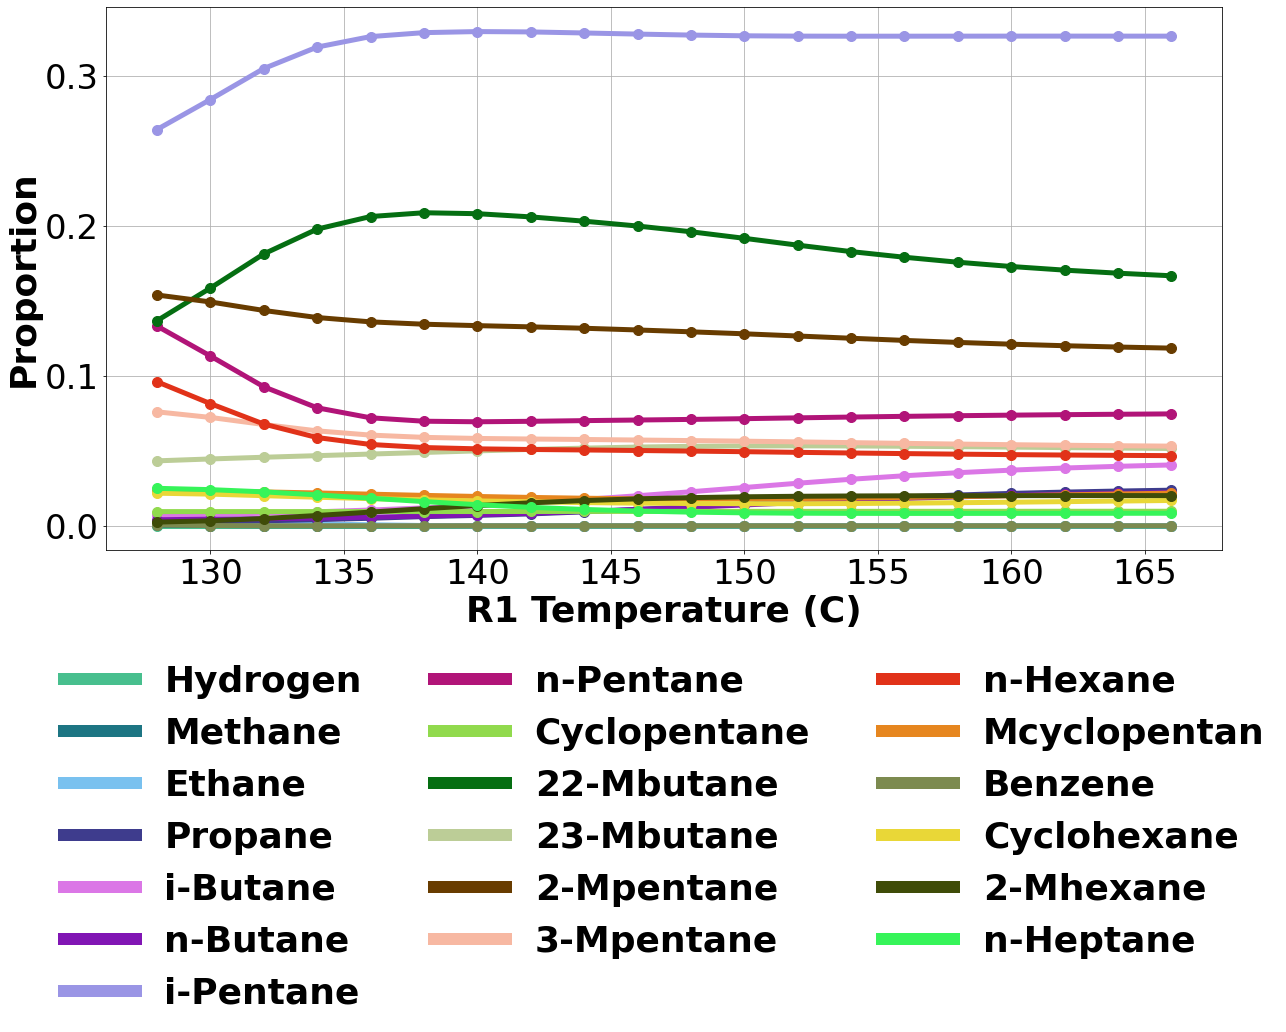

In [4]:
product_cols = [
"Hydrogen",
"Methane",
"Ethane",
"Propane",
"i-Butane",
"n-Butane",
"i-Pentane", 
"n-Pentane",
"Cyclopentane",
"22-Mbutane",
"23-Mbutane",
"2-Mpentane",
"3-Mpentane",
"n-Hexane",
"Mcyclopentan",
"Benzene",
"Cyclohexane",
"2-Mhexane",
"n-Heptane"]
product_colors = ["#48bf8e", "#1d7583", "#79c1ef", "#3e3c8d", "#db77e6", "#8115b4", "#9a95e5", "#b11478", "#91da4d", "#056e12", "#bccd97", "#683c00", "#f7b8a2", "#e13219", "#e6861f", "#7c8a4f", "#e9d737", "#3f4c08", "#36f459"]

f, ax = plt.subplots(1, 1, figsize=(20, 10))
for col, color in zip(product_cols, product_colors):
    ax.plot(sdf['r1_temp'], sdf['process_%s' % col], linewidth=5, marker='o', markersize=10, label=col, color=color)

ax.tick_params(axis='x', labelsize=34)
ax.tick_params(axis='y', labelsize=34)
ax.set_xlabel('R1 Temperature (C)', fontsize=36, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=36, fontweight='bold')
ax.grid('both')
legend = ax.legend(loc='upper center', 
                  frameon=False,
                  bbox_to_anchor=(0.5, -.15),
                  fancybox=False, 
                  shadow=False,
                  ncol=3,
                  prop={'weight':'bold', 'size':36})
for line in legend.get_lines():
    line.set_linewidth(12.0)

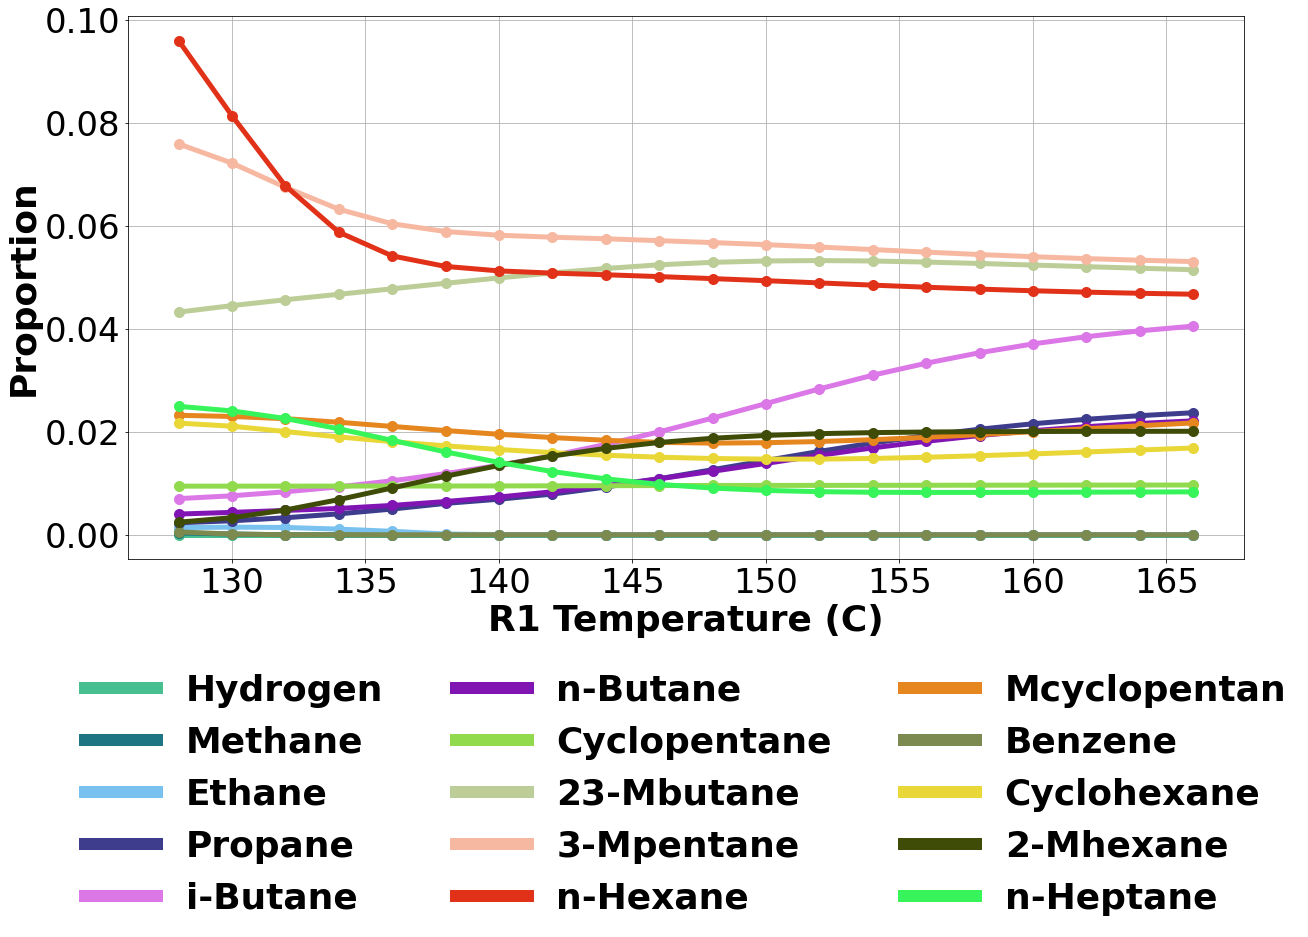

In [5]:
col_maxes = np.array([np.max(sdf['process_%s' % c]) for c in product_cols])
eligible_cols = col_maxes < 0.1
small_product_cols = np.array(product_cols)[eligible_cols]
small_product_colors = np.array(product_colors)[eligible_cols]

f, ax = plt.subplots(1, 1, figsize=(20, 10))
for col, color in zip(small_product_cols, small_product_colors):
    ax.plot(sdf['r1_temp'], sdf['process_%s' % col], linewidth=5, marker='o', markersize=10, label=col, color=color)

ax.tick_params(axis='x', labelsize=34)
ax.tick_params(axis='y', labelsize=34)
ax.set_xlabel('R1 Temperature (C)', fontsize=36, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=36, fontweight='bold')
ax.grid('both')
legend = ax.legend(loc='upper center', 
                  frameon=False,
                  bbox_to_anchor=(0.5, -.15),
                  fancybox=False, 
                  shadow=False,
                  ncol=3,
                  prop={'weight':'bold', 'size':36})
for line in legend.get_lines():
    line.set_linewidth(12.0)

# Spearman Correlations of Process Products

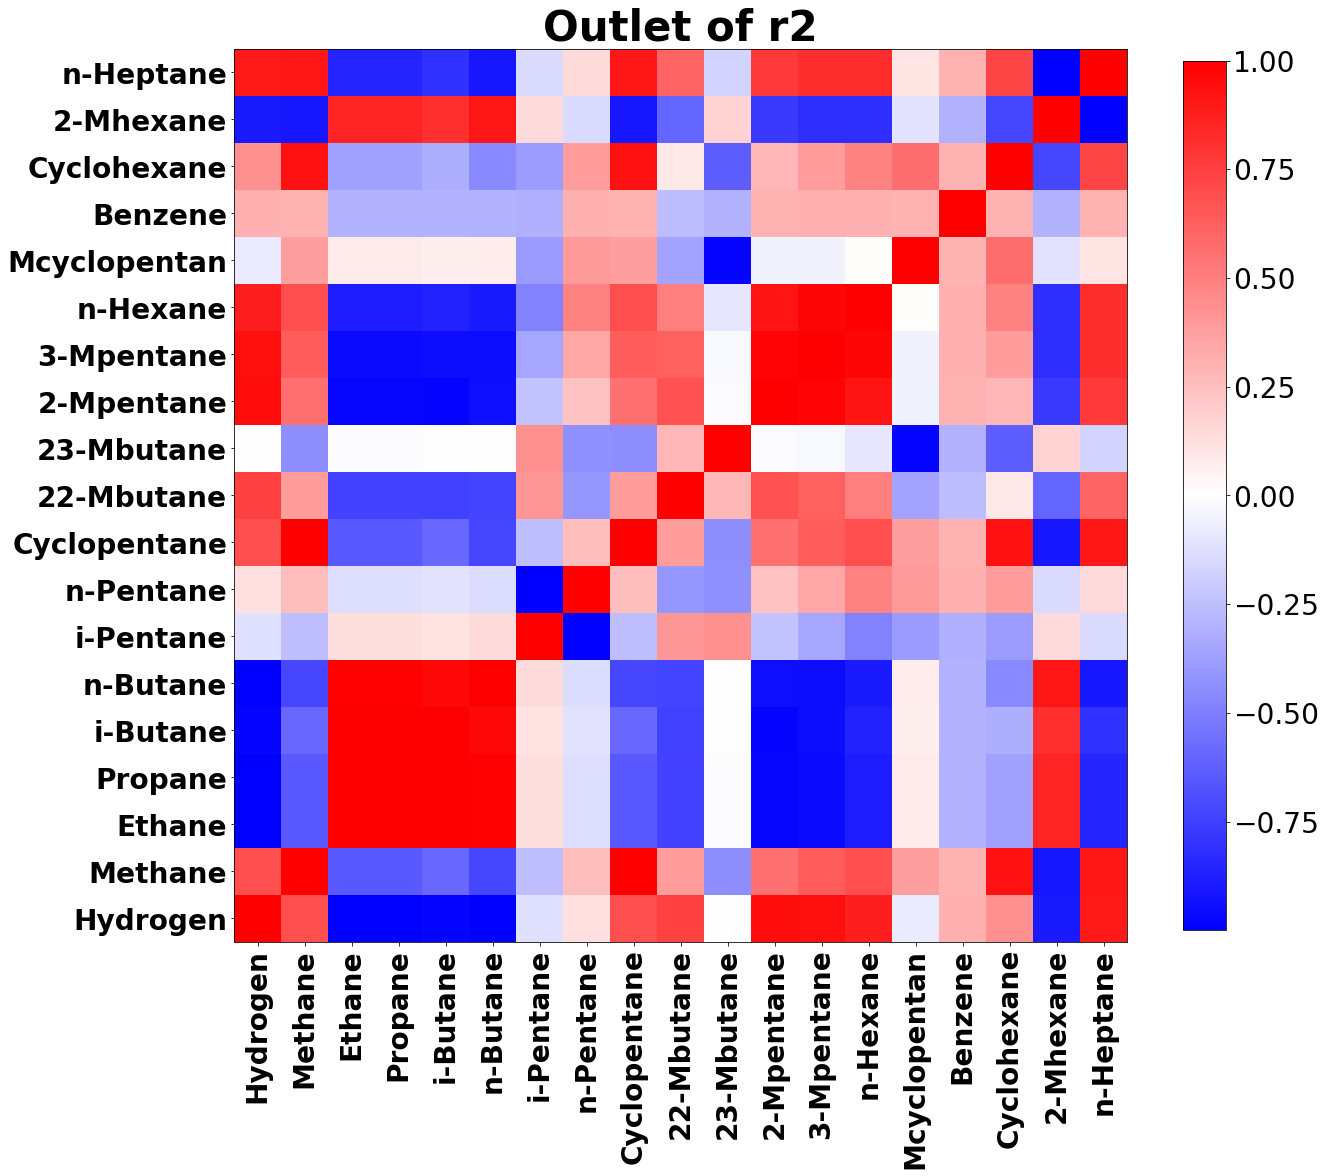

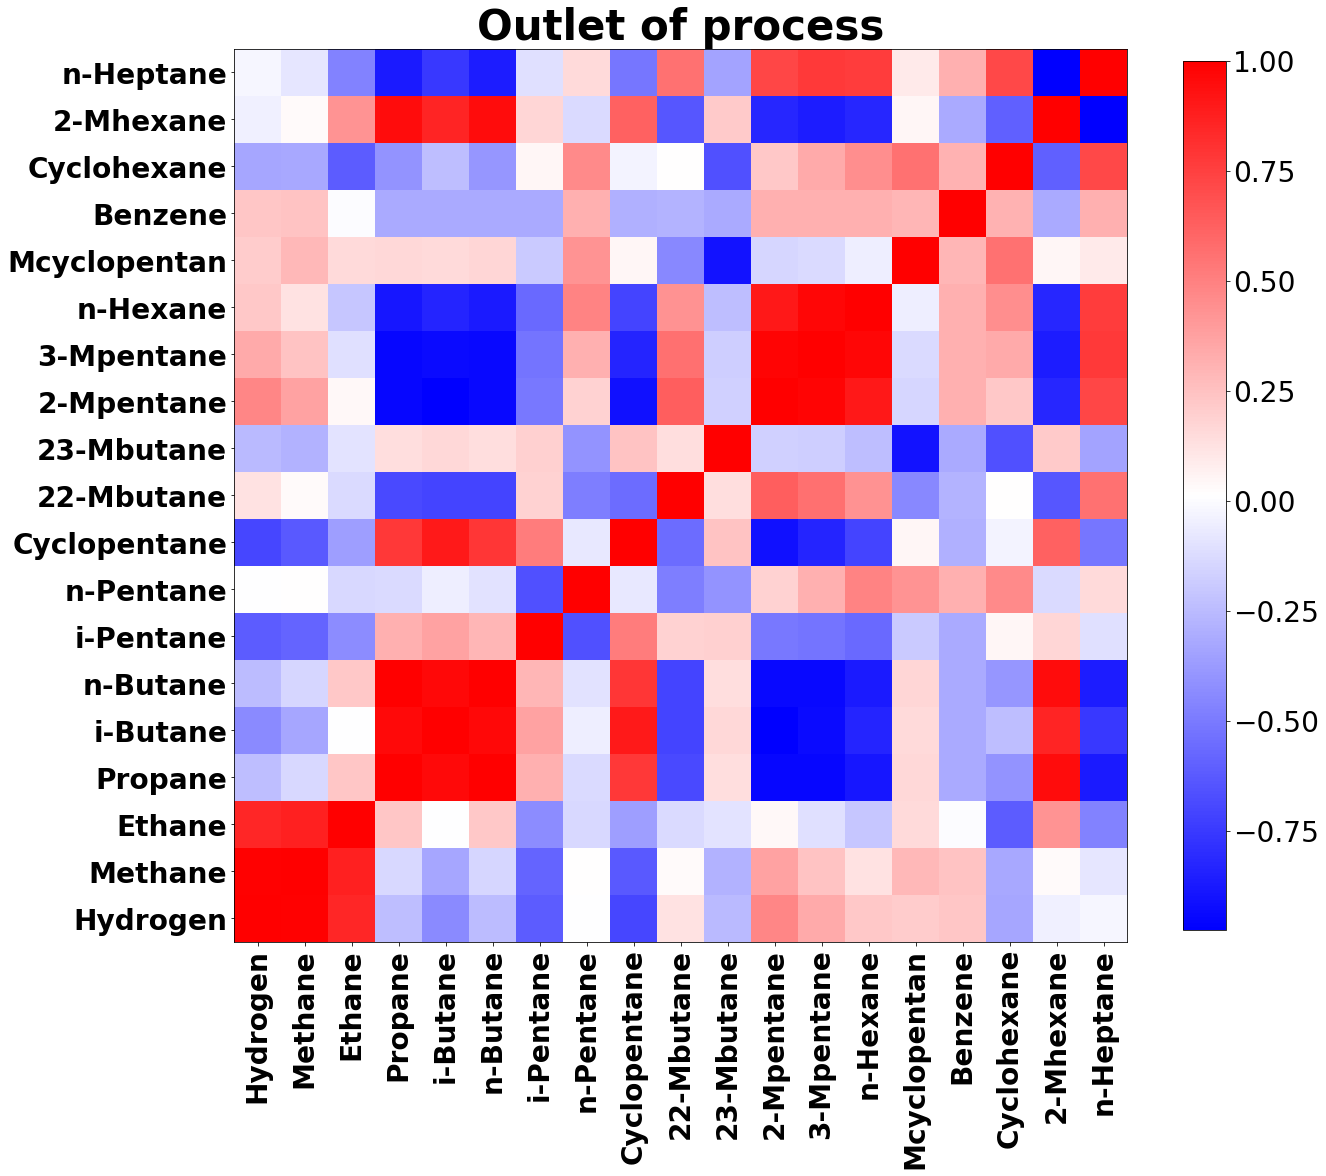

In [6]:
product_cols = [
"Hydrogen",
"Methane",
"Ethane",
"Propane",
"i-Butane",
"n-Butane",
"i-Pentane", 
"n-Pentane",
"Cyclopentane",
"22-Mbutane",
"23-Mbutane",
"2-Mpentane",
"3-Mpentane",
"n-Hexane",
"Mcyclopentan",
"Benzene",
"Cyclohexane",
"2-Mhexane",
"n-Heptane"]

for outlet in ['r2', 'process']:
    actual_cols = ["%s_%s" % (outlet, c) for c in product_cols]
    
#     Z = rng.random((df.shape[0], len(product_cols)))
#     Z = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
#     df[actual_cols] = Z
    corr_mat = df[actual_cols].corr('spearman')
    n = len(actual_cols)

    f, ax = plt.subplots(1, 1, figsize=(20, 20))
    im = ax.imshow(corr_mat, origin='lower', cmap='bwr')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(product_cols, rotation=90, fontsize=28, fontweight='bold')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(product_cols, fontsize=28, fontweight='bold')
    cbar = f.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=28) 
    ax.set_title("Outlet of %s" % outlet, fontsize=42, fontweight='bold')

# Globally optimize targets

In [30]:
target_cols = ['r2_ron', 'r2_pin', 'r2_c4yield', 'r2_c5yield', 'r1_charge_heater', 'process_ron', 'process_yield']
target_modes = [np.argmax, np.argmax, np.argmax, np.argmax, np.argmin, np.argmax, np.argmax]

monitored_cols = target_cols + ['r1_temp', 'r1_pressure', 'r2_temp', 'r2_pressure']

ffdf = df[df['r1_charge_heater'] >= 0]

ixs = []
for target_col, target_mode in zip(target_cols, target_modes):
    ix_best = target_mode(ffdf[target_col])
    ixs.append(ix_best)

global_sol = ffdf.iloc[ixs][monitored_cols].copy()
global_sol.index = target_cols
global_sol.index.rename('optimization target', inplace=True)
global_sol['optimization mode'] = [tm.__name__.replace('arg','') for tm in target_modes]
global_sol = global_sol[['optimization mode'] + list(global_sol.columns)[:-1]]
global_sol['r1_charge_heater'] /= 1000000
global_sol

,optimization mode,r2_ron,r2_pin,r2_c4yield,r2_c5yield,r1_charge_heater,process_ron,process_yield,r1_temp,r1_pressure,r2_temp,r2_pressure
optimization target,,,,,,,,,,,,
r2_ron,max,84.666644,136.700585,0.024689,0.070684,3.443284,84.333626,96.210143,166.0,50.0,146.0,70.0
r2_pin,max,83.886687,136.795042,0.073689,0.210933,4.176121,83.422255,98.350487,148.0,50.0,144.0,90.0
r2_c4yield,max,83.511172,132.291606,0.671690,1.777076,11.349396,83.375936,96.788835,148.0,90.0,166.0,50.0
r2_c5yield,max,83.511172,132.291606,0.671690,1.777076,11.349396,83.375936,96.788835,148.0,90.0,166.0,50.0
r1_charge_heater,min,84.189062,134.191270,0.008470,0.026688,0.000697,83.733951,96.816773,162.0,90.0,134.0,90.0
process_ron,max,84.611823,136.182769,0.044744,0.125438,5.289324,84.399594,95.958417,166.0,50.0,152.0,90.0
process_yield,max,76.919326,101.362343,0.018302,0.086894,5.977331,77.084749,100.294469,128.0,90.0,128.0,90.0


In [8]:
global_sol.to_excel("tmp/global_optima.xlsx")

# Plot optimization landscape of targets as a function of the four process parameters

Text(0.5, 0.98, 'Effect on Process RON')

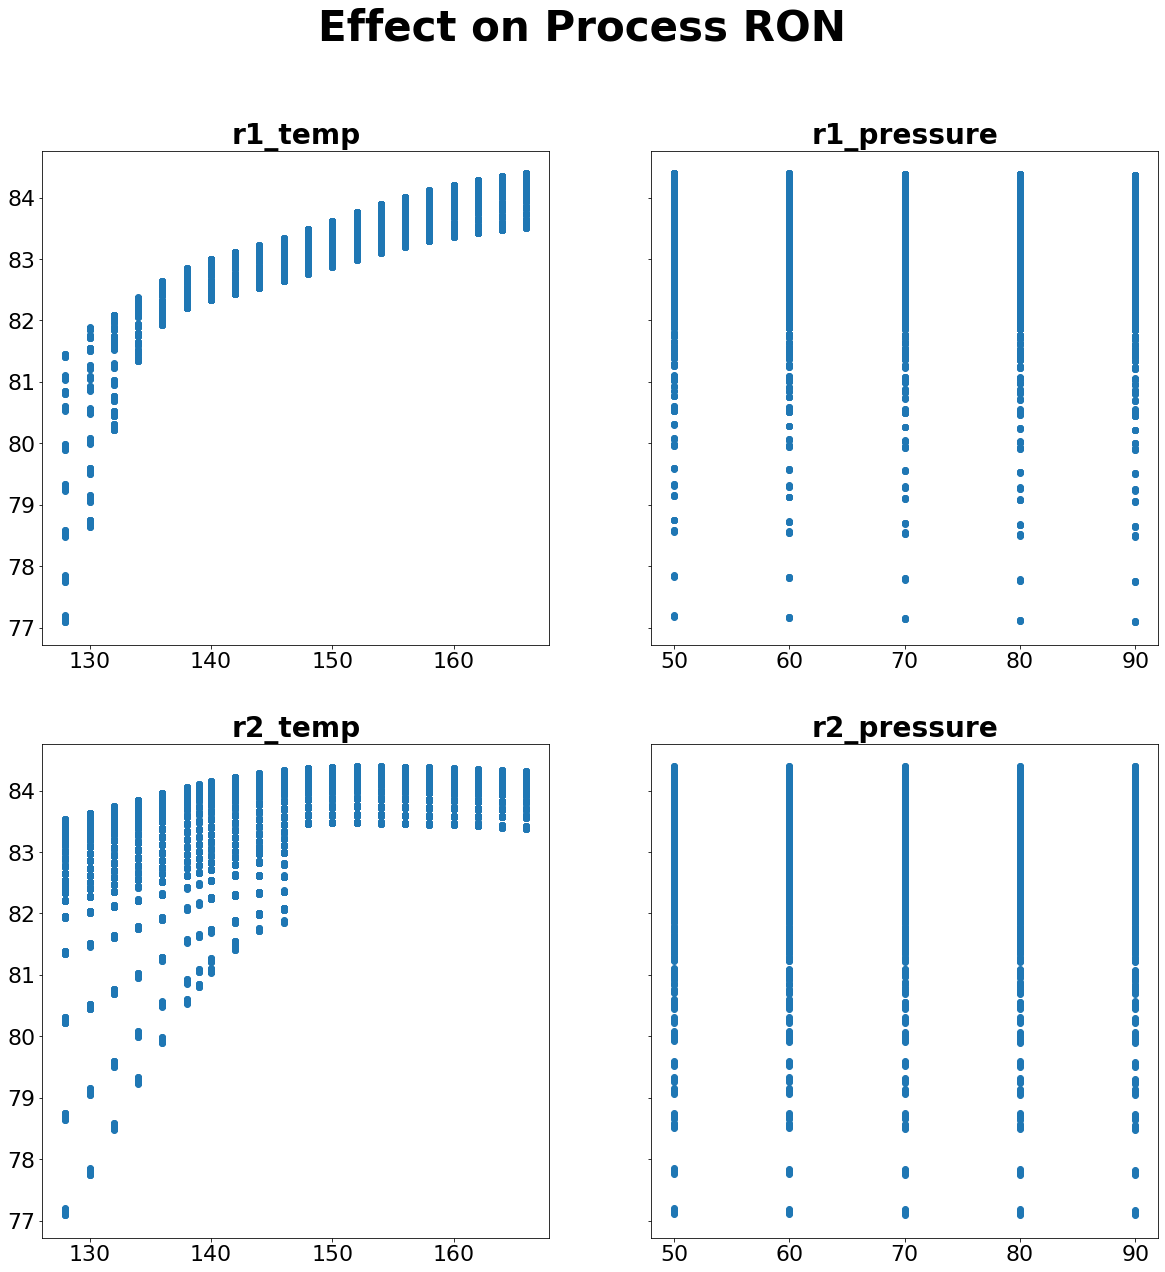

In [9]:
dependent_var = 'process_ron'
independent_vars = ['r1_temp', 'r1_pressure', 'r2_temp', 'r2_pressure']

f, axes = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, iv in enumerate(independent_vars):
    ax = axes[i]
    ax.plot(df[iv], df[dependent_var], 'o')
    ax.set_title(iv, fontsize=28, fontweight='bold')
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
f.suptitle('Effect on Process RON', fontsize=42, fontweight='bold')

Text(0.5, 0.98, 'Effect on Process Yield')

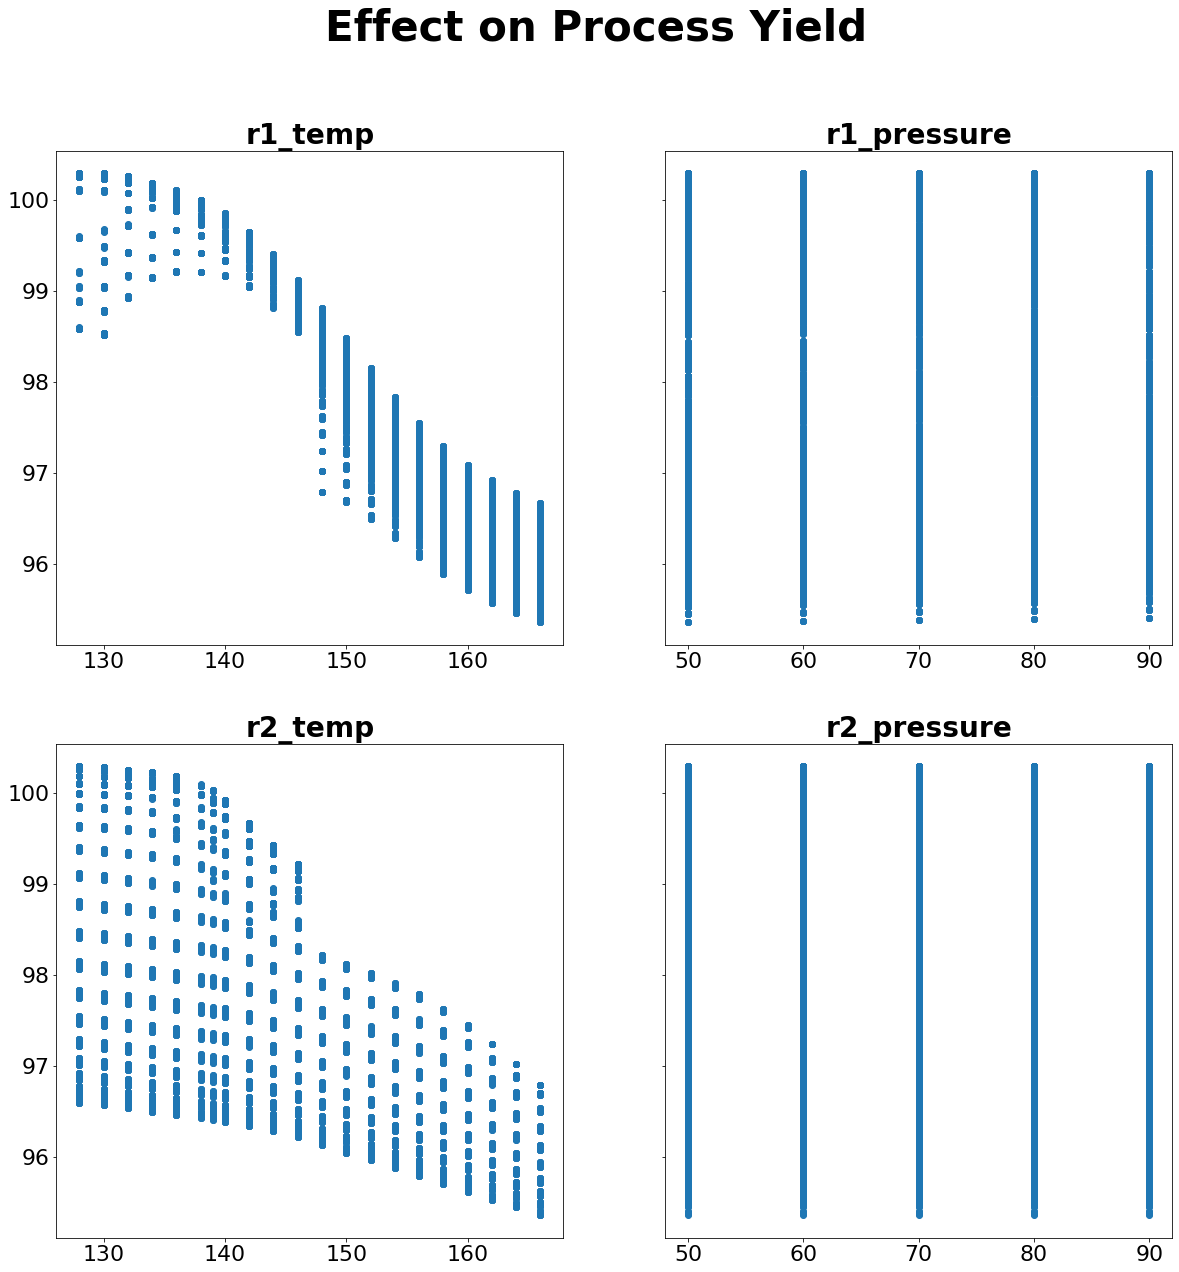

In [10]:
dependent_var = 'process_yield'
independent_vars = ['r1_temp', 'r1_pressure', 'r2_temp', 'r2_pressure']

f, axes = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
axes = axes.flatten()
for i, iv in enumerate(independent_vars):
    ax = axes[i]
    ax.plot(df[iv], df[dependent_var], 'o')
    ax.set_title(iv, fontsize=28, fontweight='bold')
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
f.suptitle('Effect on Process Yield', fontsize=42, fontweight='bold')

# Effect of R1 and R2 on Process RON

Text(0.5, 1.0, 'Process RON')

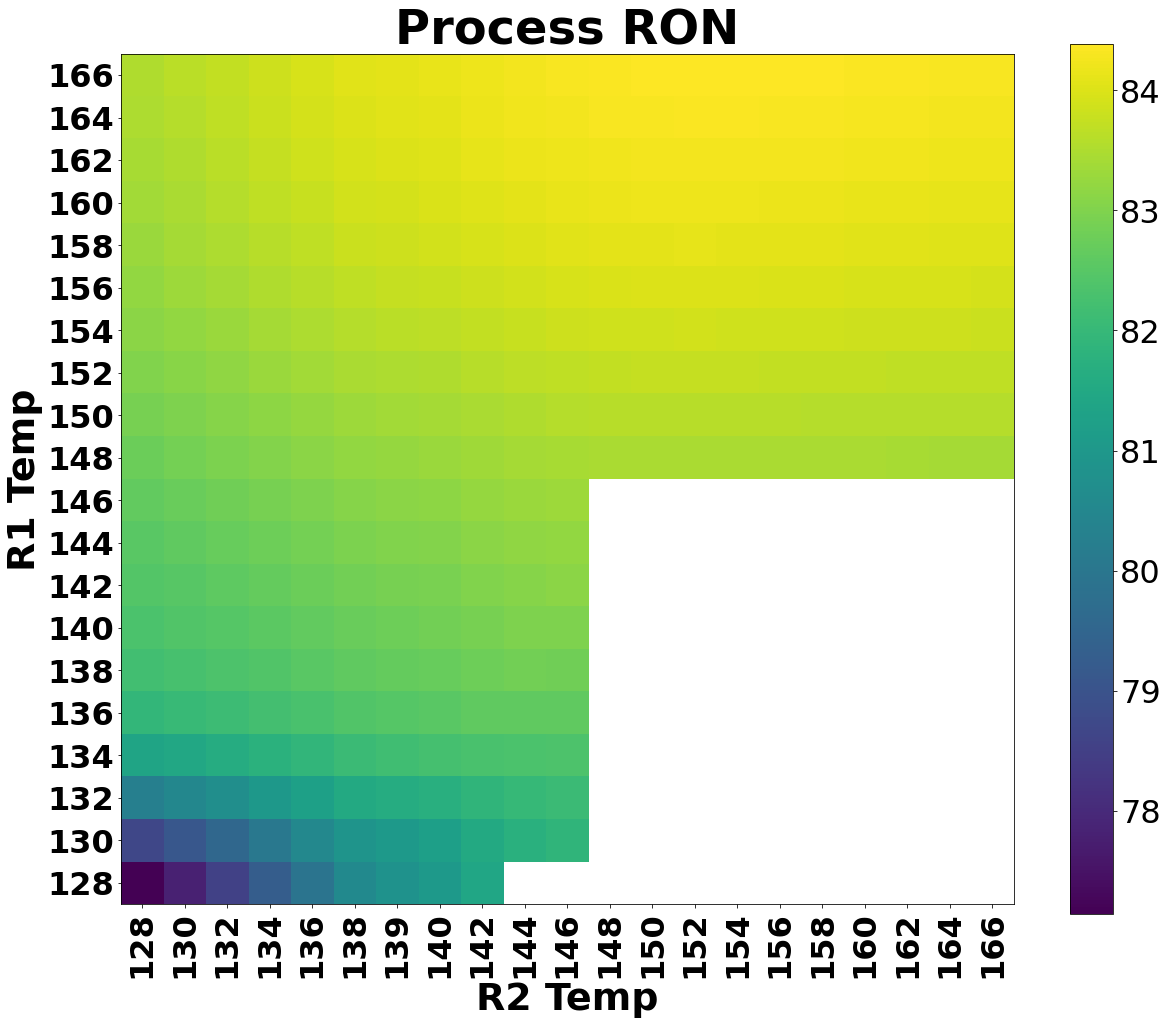

In [27]:
r1s = sorted(set(df['r1_temp']))
r2s = sorted(set(df['r2_temp']))
dependent_var = 'process_ron'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 
ax.set_title('Process RON', fontsize=48, fontweight='bold')

Text(0.5, 1.0, 'Process Yield')

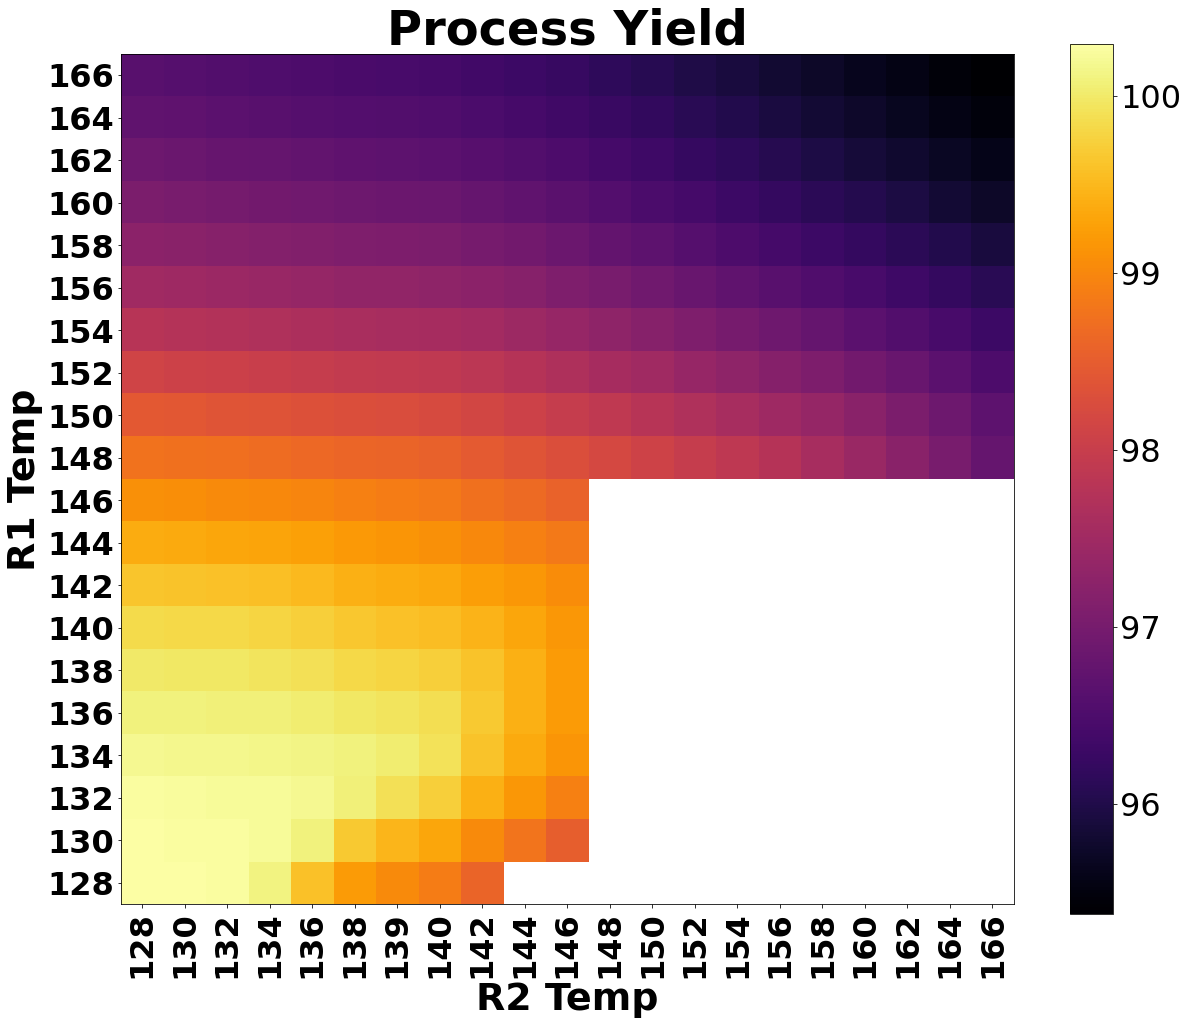

In [28]:
r1s = sorted(set(df['r1_temp']))
r2s = sorted(set(df['r2_temp']))
dependent_var = 'process_yield'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', cmap='inferno')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 
ax.set_title('Process Yield', fontsize=48, fontweight='bold')

Text(0.5, 1.0, 'Charge Heater (GJ/Hour)')

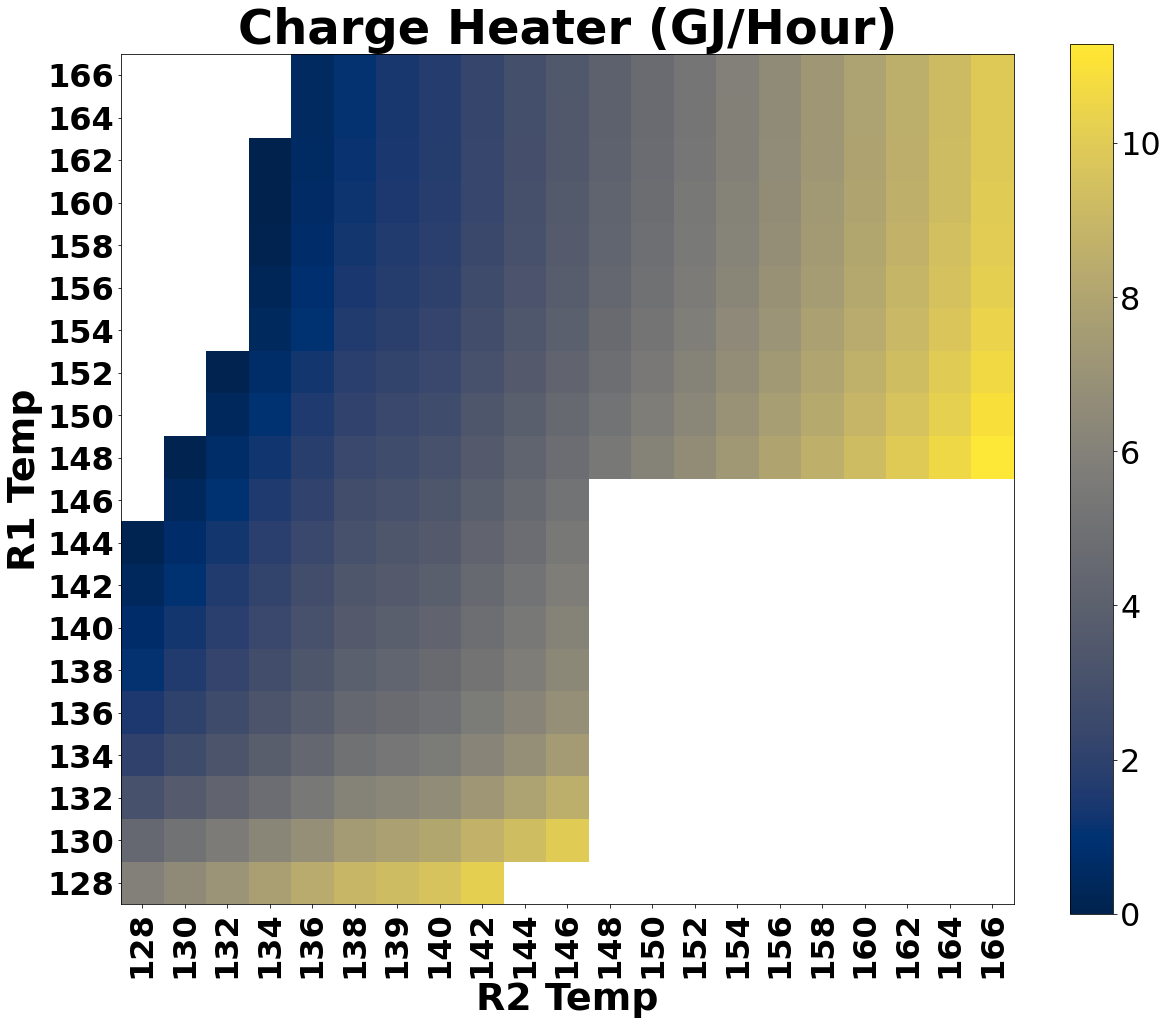

In [29]:
r1s = sorted(set(df['r1_temp']))
r2s = sorted(set(df['r2_temp']))
dependent_var = 'r1_charge_heater'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t) & (df['r1_charge_heater'] >= 0)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

M = M / (1000*1000)
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0, cmap='cividis')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 

ax.set_title('Charge Heater (GJ/Hour)', fontsize=48, fontweight='bold')

# Constrained Optimization of Charge Heater

In [56]:
min_ch = np.min(df[df['r1_charge_heater'] > 0]['r1_charge_heater'])
print("Min CH: %f" % min_ch)

thres_ron = [82, 82.5, 83.0, 83.5, 84.0]
thres_yield = [95, 96, 97, 98, 99]

results = []
matrix_format = []
for min_ron in thres_ron:
    
    row = np.zeros(len(thres_yield))
    matrix_format.append(row)
    
    for j, min_yield in enumerate(thres_yield):
        
        ix = (ffdf['process_ron'] >= min_ron) & (ffdf['process_yield'] >= min_yield)
        
        if np.sum(ix) > 0:
            sdf = ffdf[ix]
            
            best_ix = np.argmin(sdf['r1_charge_heater'])
            best_index = sdf.index[best_ix]
            
            results.append((min_ron, min_yield, best_index)) 
            
            fold_increase = ffdf.loc[best_index]['r1_charge_heater']
            
            row[j] = fold_increase
matrix_format = np.array(matrix_format)
results = np.array(results)
matrix_df = pd.DataFrame(data=matrix_format, columns=thres_yield, index=thres_ron)
matrix_df.to_csv("tmp/matrix_format.csv",index=True)

Min CH: 696.953257


In [55]:
constrained_sol = ffdf.loc[results[:,2]][monitored_cols].copy()
constrained_sol['min_ron'] = results[:,0]
constrained_sol['min_yield'] = results[:,1]
constrained_sol['increase_in_energy'] = (constrained_sol['r1_charge_heater'] - min_ch) / min_ch
constrained_sol.to_csv("tmp/constrained_sol.csv",index=True)

Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Charge Heater')

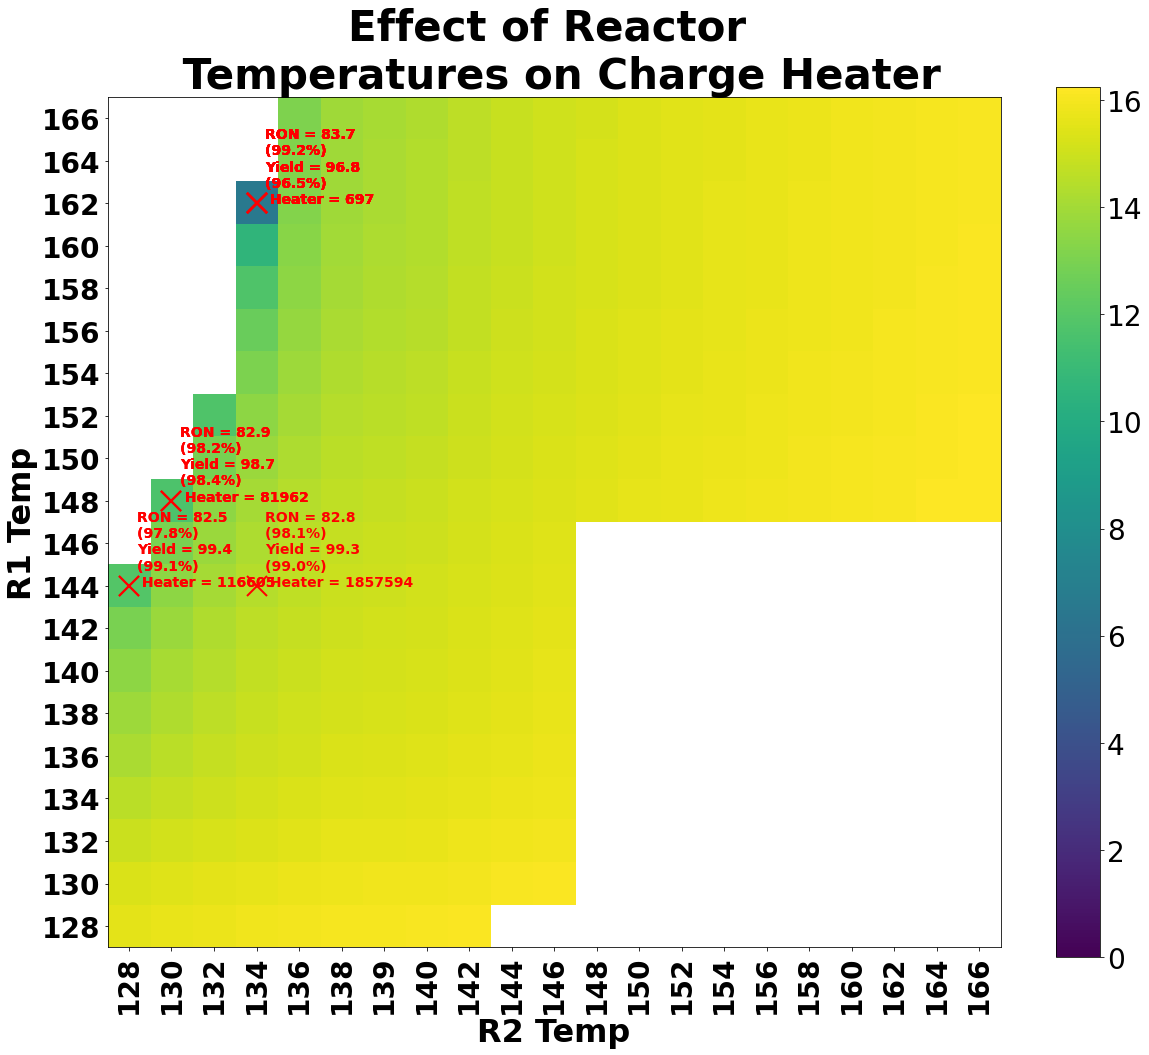

In [143]:
r1s = sorted(set(df['r1_temp']))
r1idxs = dict(zip(r1s, range(len(r1s))))
r2s = sorted(set(df['r2_temp']))
r2idxs = dict(zip(r2s, range(len(r2s))))
dependent_var = 'r1_charge_heater'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t) & (df['r1_charge_heater'] >= 0)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(np.log(M), origin='lower', vmin=0)

for r in constrained_sol.itertuples():
    r1idx = r1idxs[r.r1_temp]
    r2idx = r2idxs[r.r2_temp]
    ax.plot([r2idx], [r1idx], 'x', markersize=20, color='red', markeredgewidth=2)
    ax.annotate('RON = %4.1f\n(%4.1f%%) \nYield = %4.1f \n(%4.1f%%) \n Heater = %.0f ' % (r.process_ron, 
                                                                                r.process_ron * 100 / max_ron, 
                                                                                r.process_yield,
                                                                                r.process_yield * 100 / max_yield,
                                                                                r.r1_charge_heater), 
            (r2idx, r1idx), (r2idx+0.2, r1idx), fontsize=14, color='red', fontweight='bold')
    
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Charge Heater', fontsize=42, fontweight='bold')

140.000000,146.000000
142.000000,142.000000
142.000000,144.000000
142.000000,146.000000
144.000000,139.000000
144.000000,140.000000
144.000000,142.000000
144.000000,144.000000
144.000000,146.000000
146.000000,136.000000
146.000000,138.000000
146.000000,139.000000
146.000000,140.000000
146.000000,142.000000
146.000000,144.000000
146.000000,146.000000
148.000000,134.000000
148.000000,136.000000
148.000000,138.000000
148.000000,139.000000
148.000000,140.000000
148.000000,142.000000
148.000000,144.000000
148.000000,146.000000
148.000000,148.000000
148.000000,150.000000
148.000000,152.000000
150.000000,132.000000
150.000000,134.000000
150.000000,136.000000
150.000000,138.000000
150.000000,139.000000
150.000000,140.000000
150.000000,142.000000
150.000000,144.000000
150.000000,146.000000
152.000000,132.000000
152.000000,134.000000
152.000000,136.000000


Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Charge Heater')

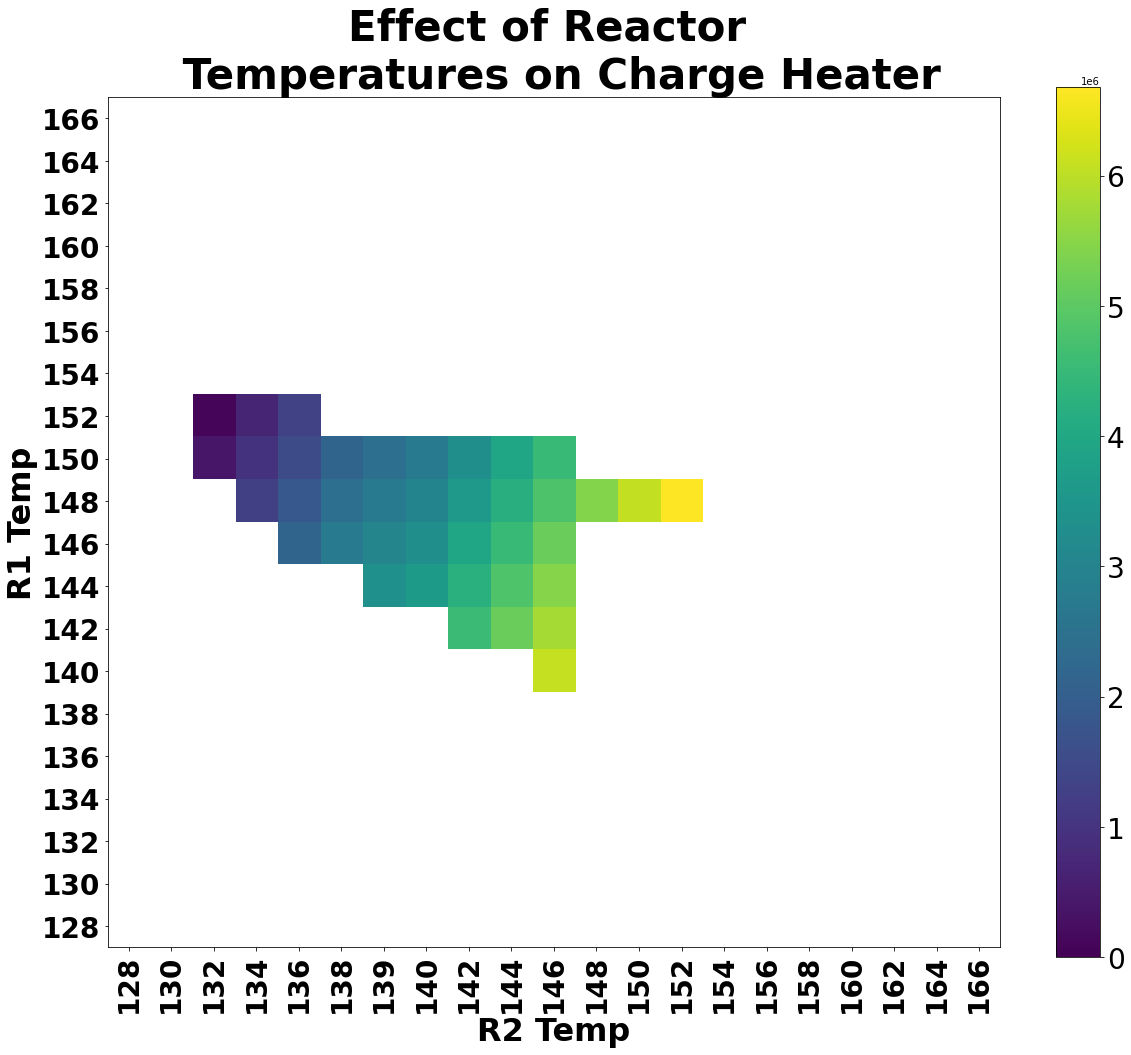

In [5]:
r1s = sorted(set(df['r1_temp']))
r1idxs = dict(zip(r1s, range(len(r1s))))
r2s = sorted(set(df['r2_temp']))
r2idxs = dict(zip(r2s, range(len(r2s))))
dependent_var = 'r1_charge_heater'

yield_var = 'process_yield'
ron_var = 'process_ron'
min_yield = 98
min_ron = 83

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = df[(df['r1_temp'] == r1t) & (df['r2_temp'] == r2t) & (df['r1_charge_heater'] >= 0)]
        mean_dep = np.mean(sdf[dependent_var])
        yields = sdf[yield_var]
        rons = sdf[ron_var]
        
        if np.any((yields >= min_yield) & (rons >= min_ron)):
            print("%f,%f" % (r1t,r2t))
            M[i, j] = mean_dep
        else:
            M[i, j] = np.nan

n,m = M.shape
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0)

ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Charge Heater', fontsize=42, fontweight='bold')